# PAO-EquiML

In [1]:
import logging
import torch
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from matplotlib import colormaps
from torch_cluster import radius_graph
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_scatter import scatter
from torch.utils.data import Dataset

from e3nn import o3
from e3nn.nn import FullyConnectedNet, Gate, models
from e3nn.o3 import FullyConnectedTensorProduct
from e3nn.math import soft_one_hot_linspace
from e3nn.util.test import assert_equivariant
from e3nn.nn.models.gate_points_2101 import Network

from pathlib import Path
from pao_file_utils import parse_pao_file, append_samples, write_pao_file, read_cp2k_energy

t = torch.tensor

In [2]:
change_of_coord = t([
    # this specifies the change of basis yzx -> xyz
    [0., 0., 1.],
    [1., 0., 0.],
    [0., 1., 0.]
])
prim_basis_specs = {
    "O": "2x0e + 2x1o + 1x2e", # DZVP-MOLOPT-GTH for Oxygen: two s-shells, two p-shells, one d-shell
    "H": "2x0e + 1x1o" # DZVP-MOLOPT-GTH for Hydrogen: two s-shells, one p-shell
}
pao_basis_size = 4

In [3]:
class PAO_Object:
    def __init__(self, kind, atomkind, coords, xblock):
        self.kind = kind
        self.atomkind = atomkind
        self.coords = coords
        self.xblock = xblock
        #self.label = xblock.T @ torch.inverse(xblock @ xblock.T) @ xblock
        #self.label = xblock
        U, S, Vh = torch.linalg.svd(xblock, full_matrices=False)
        self.label = Vh
        
    def swap(self, idx, jdx):
        idxs = list(range(len(self.coords)))
        idxs[idx], idxs[jdx] = idxs[jdx], idxs[idx]
        coords_swap = self.coords.clone().detach()
        atomkind_swap = self.atomkind.copy()
        index = torch.LongTensor(idxs)
        coords_swap[index] = self.coords
        atomkind_swap[idx], atomkind_swap[jdx] = atomkind_swap[jdx], atomkind_swap[idx]
        self.coords = coords_swap
        self.atomkind = atomkind_swap

class PAO_dataset(Dataset):
    def __init__(self, pao_objects):
        self.labels = [pao_object.label for pao_object in pao_objects]
        self.atomkinds = [generate_f_in(pao_object) for pao_object in pao_objects]
        self.coords = [pao_object.coords for pao_object in pao_objects]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        coords = self.coords[idx]
        label = self.labels[idx]
        atomkind = self.atomkinds[idx]
        return coords, atomkind, label

In [4]:
def parse_pao_file_torch(path: Path):
    kinds, atom2kind, coords, xblocks = parse_pao_file(path)
    return kinds, atom2kind, t(coords, dtype=torch.float32), [t(x, dtype=torch.float32) for x in xblocks]

# Remove central atom and create PAO object from PAO file
def generate_pao_object_from_file(file_path):
    pao_objects = []
    kinds, atom2kind, coords, xblocks = parse_pao_file_torch(file_path)
    #coords = coords[:, [2, 1, 0]]
    
    #coords_swap = coords.clone().detach()
    #idxs = list(range(len(coords)))
    #idxs[1], idxs[4] = idxs[4], idxs[1]
    #idxs[2], idxs[5] = idxs[5], idxs[2]
    #index = torch.LongTensor(idxs)
    #coords_swap[index] = coords
    #coords = coords_swap
    
    #atom2kind[1], atom2kind[4] = atom2kind[4], atom2kind[1]
    #atom2kind[2], atom2kind[5] = atom2kind[5], atom2kind[2]
    #xblocks[1], xblocks[4] = xblocks[4], xblocks[1]
    #xblocks[2], xblocks[5] = xblocks[5], xblocks[2]

    #coords = torch.roll(coords, -1, 1)
    for idx, atom in enumerate(atom2kind):
        rel_coords = coords - coords[idx]
        #rel_coords = coords
        idxs = list(range(len(atom2kind)))
        #which = torch.zeros(len(atom2kind))
        #which[idx] = 1.0
        #which = which.unsqueeze(dim=1)
        #idxs[1], idxs[4] = idxs[4], idxs[1]
        #idxs[2], idxs[5] = idxs[5], idxs[2]
        idxs.pop(idx)
        pao_objects.append(PAO_Object(kinds[atom], [atom2kind[atom] for atom in idxs], rel_coords[idxs], xblocks[idx]))
    return pao_objects

In [5]:
def generate_irreps_output(pao_basis_size, atom_species):
    prim_basis_specs = {
    "O": "2x0e + 2x1o + 1x2e", # DZVP-MOLOPT-GTH for Oxygen: two s-shells, two p-shells, one d-shell
    "H": "2x0e + 1x1o" # DZVP-MOLOPT-GTH for Hydrogen: two s-shells, one p-shell
    }
    prim_basis_spec = prim_basis_specs[atom_species]
    prim_basis_size = o3.Irreps(prim_basis_spec).dim
    irreps_output = o3.Irreps(" + ".join(pao_basis_size*[prim_basis_spec]))
    return irreps_output

In [6]:
pao_objects = []
#for phi in ["00"]:
#    pao_objects.extend(generate_pao_object_from_file(Path(f"pao_ml_equivar/2H2O_rotations/phi_{phi}/2H2O_pao44-1_0.pao")))
pao_objects.extend(generate_pao_object_from_file(Path(f"2H2O_rotations/rand_10/2H2O_pao44-1_0.pao")))
#pao_objects.extend(generate_pao_object_from_file(Path(f"2H2O_rotations/phi_22/2H2O_pao44-1_0.pao"))[1:3])
pao_objects_O = [pao_object for pao_object in pao_objects if pao_object.kind.atomic_number==8]
pao_objects_H = [pao_object for pao_object in pao_objects if pao_object.kind.atomic_number==1]
kinds, atom2kind, coords, _ = parse_pao_file_torch(Path("2H2O_rotations/rand_10/2H2O_pao44-1_0.pao"))

# Irreps Input
irreps_input = o3.Irreps("2x0e") # features: is_hydrogen, is_oxygen

# Irreps Spherical Harmonics
irreps_sh = o3.Irreps.spherical_harmonics(lmax=2)

In [7]:
print(len(pao_objects_O))
print(generate_irreps_output(4,"O"))
print(len(pao_objects_H))
print(generate_irreps_output(4,"H"))
print(pao_objects_H[2].coords)

2
2x0e+2x1o+1x2e+2x0e+2x1o+1x2e+2x0e+2x1o+1x2e+2x0e+2x1o+1x2e
4
2x0e+1x1o+2x0e+1x1o+2x0e+1x1o+2x0e+1x1o
tensor([[ 0.7232, -0.6202, -3.3261],
        [ 1.2192, -1.4227, -3.5188],
        [-0.0210, -0.6253, -3.9363],
        [-0.3114, -0.7508, -0.5133],
        [ 0.0655, -0.6316, -1.3989]])


In [8]:
# Preprocessing, model, and loss functions.
max_radius = 4
num_neighbours=5

def edge_vec(coords):
    assert coords.shape[0] == num_neighbors
    return coords

def normalize(xblock):
    return xblock / torch.norm(xblock, dim=1)[:,None]

def labelfy(xblock):
    # The loss_functions requires orthonormal labels.
    U, S, Vh = torch.linalg.svd(xblock, full_matrices=False)
    return Vh

def generate_f_in(pao_object):  
    f_in = t([(k=="H", k=="O") for k in pao_object.atomkind], dtype=torch.float32)
    return f_in

def regularization(label):
    return 0.1 * (1 - torch.norm(label, dim=1)).pow(2).sum()

def loss_function_1(pred, label):
    loss = torch.sum(torch.sum((pred - label).pow(2), dim=2), dim=1).mean()
    return loss

def loss_function_diag(pred, label):
    pred_projector = torch.bmm(torch.transpose(pred, dim0=1, dim1=2), pred)
    label_projector = torch.bmm(torch.transpose(label, dim0=1, dim1=2), label)
#    label_projector = label
    residual = pred_projector - label_projector
#    return residual.pow(2).sum() + regularization(pred)
#    return torch.sum(torch.sum(residual.pow(2), dim=2), dim=1).mean()
#    return torch.sum(torch.sum(residual.pow(2), dim=2), dim=1).mean()
    return residual.abs().sum(dim=0).diag().sum()

def loss_function_2(pred, label):
    pred_projector = torch.bmm(torch.transpose(pred, dim0=1, dim1=2), pred)
    label_projector = torch.bmm(torch.transpose(label, dim0=1, dim1=2), label)
#    label_projector = label
    residual = pred_projector - label_projector
#    return residual.pow(2).sum() + regularization(pred)
#    return torch.sum(torch.sum(residual.pow(2), dim=2), dim=1).mean()
#    return torch.sum(torch.sum(residual.pow(2), dim=2), dim=1).mean()
    return residual.abs().sum()
#    return residual.pow(2).mean()

def loss_function_ortho_projector(pred, label):
    pred_projector = pred.T @ pred
    label_projector = label.T @ label
    proj_residual = pred_projector - label_projector
#    ortho_residual = torch.eye(pred.shape[0]) - pred @ pred.T
#    return residual.pow(2).sum() + regularization(pred)
#    return torch.sum(torch.sum(residual.pow(2), dim=2), dim=1).mean()
#    return torch.sum(torch.sum(residual.pow(2), dim=2), dim=1).mean()
#    return proj_residual.abs().sum() + ortho_residual.abs().sum()
    return proj_residual.pow(2).mean()

def loss_function_projector(pred, label):
    label_projector = label.T @ torch.inverse(label @ label.T) @ label
    pred_projector = pred.T @ torch.inverse(pred @ pred.T) @ pred
    residual = pred_projector - label_projector
    #orb_residual = pred.pow(2).sum(dim=0) - label.pow(2).sum(dim=0)
    #coeff_residual = pred.pow(2).sum(dim=1) - label.pow(2).sum(dim=1)
    return residual.abs().sum()
    #return residual.abs().sum() + orb_residual.abs().sum() + coeff_residual.abs().sum()

def loss_function_pred_project(pred, label):
    label_projector = label.T @ torch.inverse(label @ label.T) @ label
    proj_residual = pred.T - label_projector @ pred.T
    #rank_residual = pred.shape[0] - torch.linalg.matrix_rank(pred)
    #print(rank_residual)
    #orb_residual = pred.pow(2).sum(dim=0) - label.pow(2).sum(dim=0)
    #coeff_residual = pred.pow(2).sum(dim=1) - label.pow(2).sum(dim=1)
    #return residual.abs().sum()
    return proj_residual.abs().sum() + rank_residual.abs()

def loss_function_sect(pred, label):
    pred_projector = torch.bmm(torch.transpose(pred, dim0=1, dim1=2), pred)
    label_projector = torch.bmm(torch.transpose(label, dim0=1, dim1=2), label)
#    label_projector = label
    residual = pred_projector - label_projector
    s_residual = residual[:,:2,:2].abs().sum()
    sp_residual = residual[:,:2,2:].abs().sum() + residual[:,2:,:2].abs().sum()
    pp_residual = residual[:,2:,2:].abs().sum()
    norm_residual = torch.bmm(pred, torch.transpose(pred, dim0=1, dim1=2)) - torch.eye(4).repeat(2,1,1)
#    return residual.pow(2).sum() + regularization(pred)
#    return torch.sum(torch.sum(residual.pow(2), dim=2), dim=1).mean()
#    return torch.sum(torch.sum(residual.pow(2), dim=2), dim=1).mean()
    return s_residual**2 + sp_residual**2 + pp_residual**2 + norm_residual.abs().sum()
#    return residual.pow(2).mean()

def loss_function_tot_orb_coeff(pred, label):
    pred_projector = torch.bmm(torch.transpose(pred, dim0=1, dim1=2), pred)
    label_projector = torch.bmm(torch.transpose(label, dim0=1, dim1=2), label)
    residual = pred_projector - label_projector
    orb_residual = pred.pow(2).sum(dim=1) - label.pow(2).sum(dim=1)
    coeff_residual = pred.pow(2).sum(dim=2) - label.pow(2).sum(dim=2)
    return residual.abs().sum() + orb_residual.abs().sum() + coeff_residual.abs().sum()

In [9]:
def model_O(edge_vec, f_in):
    sh = o3.spherical_harmonics(irreps_sh, edge_vec, normalize=True, normalization='component')
    emb = soft_one_hot_linspace(edge_vec.norm(dim=1), 0.0, max_radius, num_distances,
                                basis='smooth_finite', cutoff=True).mul(num_distances**0.5)
    flat_xyz = tp_O(f_in, sh, fc_O(emb)).sum(dim=0).div(num_neighbours**0.5)
    flat_yzx = torch.matmul(flat_xyz, D_O)
    return flat_yzx.reshape(pao_basis_size, prim_basis_size)

In [77]:
tp_O = o3.FullyConnectedTensorProduct(irreps_input, irreps_sh, generate_irreps_output(4, "O"), shared_weights=False)

/Users/Vincente/anaconda3/envs/e3nn/lib/python3.11/site-packages/torch/jit/_check.py:172: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn("The TorchScript type system doesn't support "


In [51]:
# Perceptron
num_distances = 10
num_layers = 16
fc_O = FullyConnectedNet([num_distances, num_layers, tp_O.weight_numel], torch.relu)
print("Oxygen, Number of parameters: ", sum(p.numel() for p in fc_O.parameters()))

Oxygen, Number of parameters:  800


In [52]:
batch_size = 1
dataset_O = PAO_dataset(pao_objects_O)
training_loader_O = DataLoader(dataset_O, batch_size=batch_size, shuffle=False)
prim_basis_spec = prim_basis_specs["O"]
prim_basis_size = o3.Irreps(prim_basis_spec).dim
irreps_output = o3.Irreps(" + ".join(pao_basis_size*[prim_basis_spec]))
D_O = irreps_output.D_from_matrix(change_of_coord)
#plt.imshow(D_O)

In [53]:
batch_size = 1
data_O = []
#dataset_H = PAO_dataset(pao_objects_H)
#training_loader_H = DataLoader(dataset_H, batch_size=batch_size, shuffle=True)

for pao_object in pao_objects_O:
    data_O += [
        Data(
            x=None, pos=pao_object.coords, y=pao_object.label, z=generate_f_in(pao_object)
        )
    ]
train_loader_O = DataLoader(
    data_O, batch_size=batch_size, shuffle=False
)

In [478]:
model_O = Network(
    irreps_in=None,
    irreps_hidden="64x0e+32x1o+16x2e+8x3o+8x4e",
    #irreps_out="2x0e + 3x0o + 2x0e + 3x0o + 2x0e + 3x0o + 2x0e + 3x0o",
    irreps_out=irreps_output,
    irreps_node_attr="2x0e",
    irreps_edge_attr=o3.Irreps.spherical_harmonics(2),
    layers=3,
    max_radius=6.0,
    number_of_basis=10,
    radial_layers=1,
    radial_neurons=128,
    num_neighbors=4,
    num_nodes=5,
    reduce_output=True
)

In [609]:
# Train the model.
optim = torch.optim.Adam(fc_O.parameters(), lr=1e-3)
train_loss_O = []

#for step in range(10001):
#    edge_vecs, atomkinds, label = next(iter(training_loader_O))
#    pred = model_O(edge_vecs, atomkinds)
#    loss = loss_function_1(pred, label)
#    optim.zero_grad()
#    loss.backward()
#    optim.step()
#    if step % 1000 == 0:
#        print(f"warm up  {step:5d} | loss {loss:.8e}")

        
for step in range(10001):
    temp_loss = 0
    i = 0
    for x in data_O:
        edge_vecs = x.pos
        atomkinds = x.z
        label = x.y
        #x = next(iter(train_loader_H))
        #pred = torch.matmul(model_H(x), D_H).reshape(batch_size, pao_basis_size, prim_basis_size)
        #label = x.y.reshape(batch_size, pao_basis_size, prim_basis_size)
        #edge_vecs, atomkinds, label = next(iter(training_loader_H))
        pred = model_O(edge_vecs, atomkinds)
        loss = loss_function_projector(pred, label)
        optim.zero_grad()
        loss.backward()
        optim.step()
        if step % 100 == 0:
            temp_loss += loss.detach()
            i+=1
    if step % 100 == 0:
        temp_loss /= i
        train_loss_O.append(temp_loss)
        print(f"training {step:5d} | loss {temp_loss:.8e}")

training     0 | loss 6.21037140e+01
training   100 | loss 2.19839439e+01
training   200 | loss 9.23480320e+00
training   300 | loss 5.54284525e+00
training   400 | loss 3.56677079e+00
training   500 | loss 2.62928820e+00
training   600 | loss 2.06335449e+00
training   700 | loss 1.64009523e+00
training   800 | loss 1.34806991e+00
training   900 | loss 1.17143083e+00
training  1000 | loss 1.10637689e+00
training  1100 | loss 1.04304039e+00
training  1200 | loss 9.76624787e-01
training  1300 | loss 9.16333556e-01
training  1400 | loss 8.31338525e-01
training  1500 | loss 7.24947631e-01
training  1600 | loss 6.84456468e-01
training  1700 | loss 6.70600474e-01
training  1800 | loss 6.47073865e-01
training  1900 | loss 6.27194285e-01
training  2000 | loss 6.01103306e-01
training  2100 | loss 5.62108815e-01
training  2200 | loss 4.90683258e-01
training  2300 | loss 4.10515577e-01
training  2400 | loss 3.91256034e-01
training  2500 | loss 3.72313976e-01
training  2600 | loss 3.61652970e-01
t

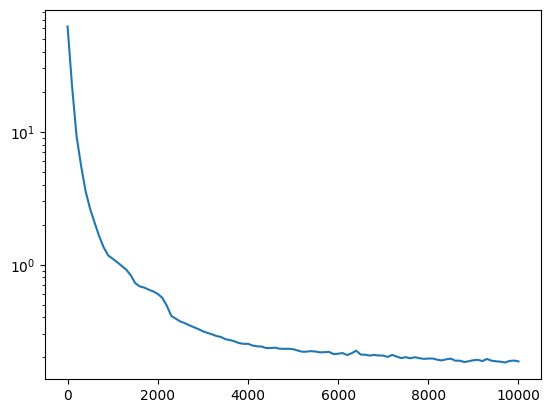

In [610]:
plt.plot(list(range(0, 10001,100)), train_loss_O)
plt.yscale("log")
plt.show()

In [493]:
torch.save(model_O.state_dict(), "./model_O.param")

tensor([9.6905e-01, 3.2980e-02, 9.6800e-01, 9.8655e-01, 9.6075e-01, 2.6760e-02,
        1.2626e-02, 3.7170e-02, 1.1062e-03, 9.6588e-04, 6.0310e-04, 8.7486e-04,
        9.3496e-04])
tensor([9.6899e-01, 3.2969e-02, 9.8734e-01, 9.8578e-01, 9.3724e-01, 3.4515e-02,
        1.9936e-02, 2.7680e-02, 1.0615e-03, 8.4626e-04, 1.6238e-05, 1.1508e-03,
        3.3264e-05], grad_fn=<SumBackward1>)


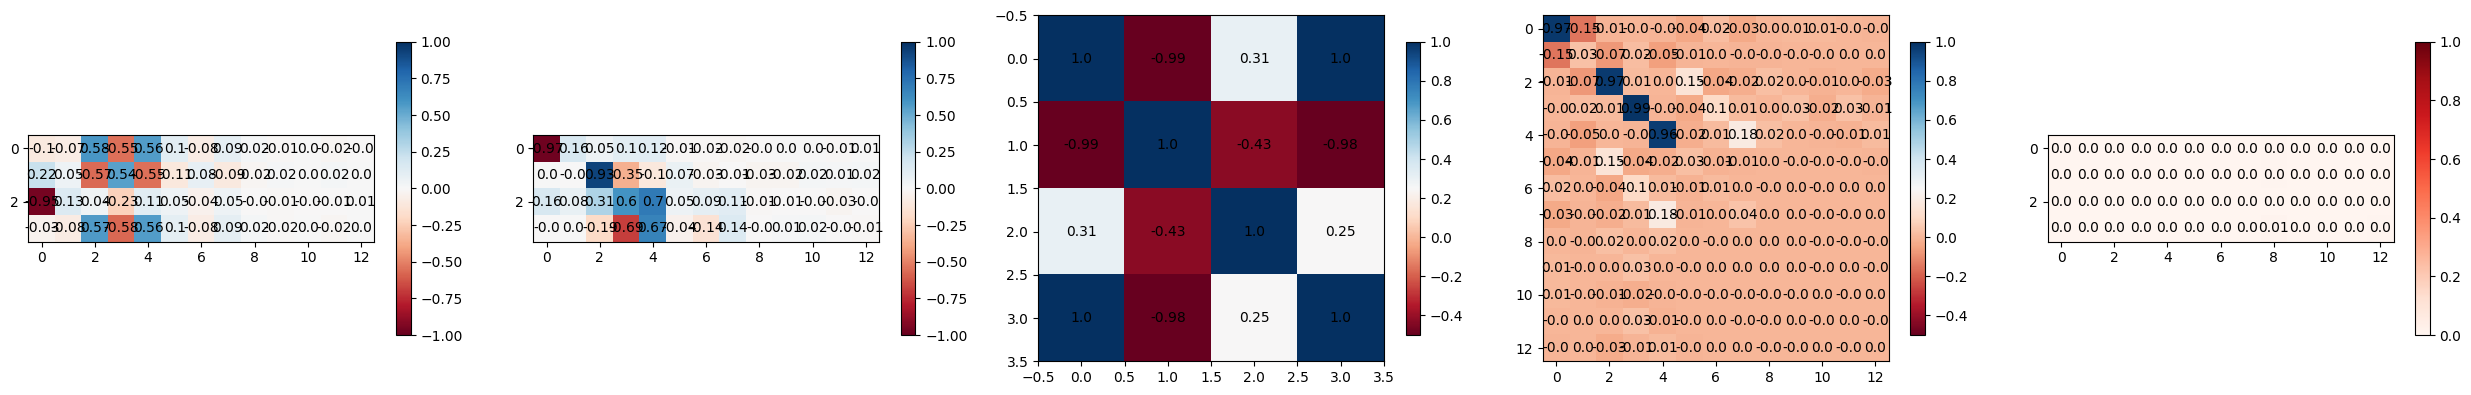

2H2O_rotations/phi_00/2H2O_pao44-1_0.pao: 4.046844e-02
tensor([9.6905e-01, 3.2980e-02, 9.6800e-01, 9.8655e-01, 9.6075e-01, 2.6760e-02,
        1.2626e-02, 3.7170e-02, 1.1062e-03, 9.6588e-04, 6.0310e-04, 8.7486e-04,
        9.3496e-04])
tensor([9.6899e-01, 3.2969e-02, 9.8734e-01, 9.8578e-01, 9.3724e-01, 3.4515e-02,
        1.9936e-02, 2.7680e-02, 1.0615e-03, 8.4626e-04, 1.6238e-05, 1.1508e-03,
        3.3264e-05], grad_fn=<SumBackward1>)


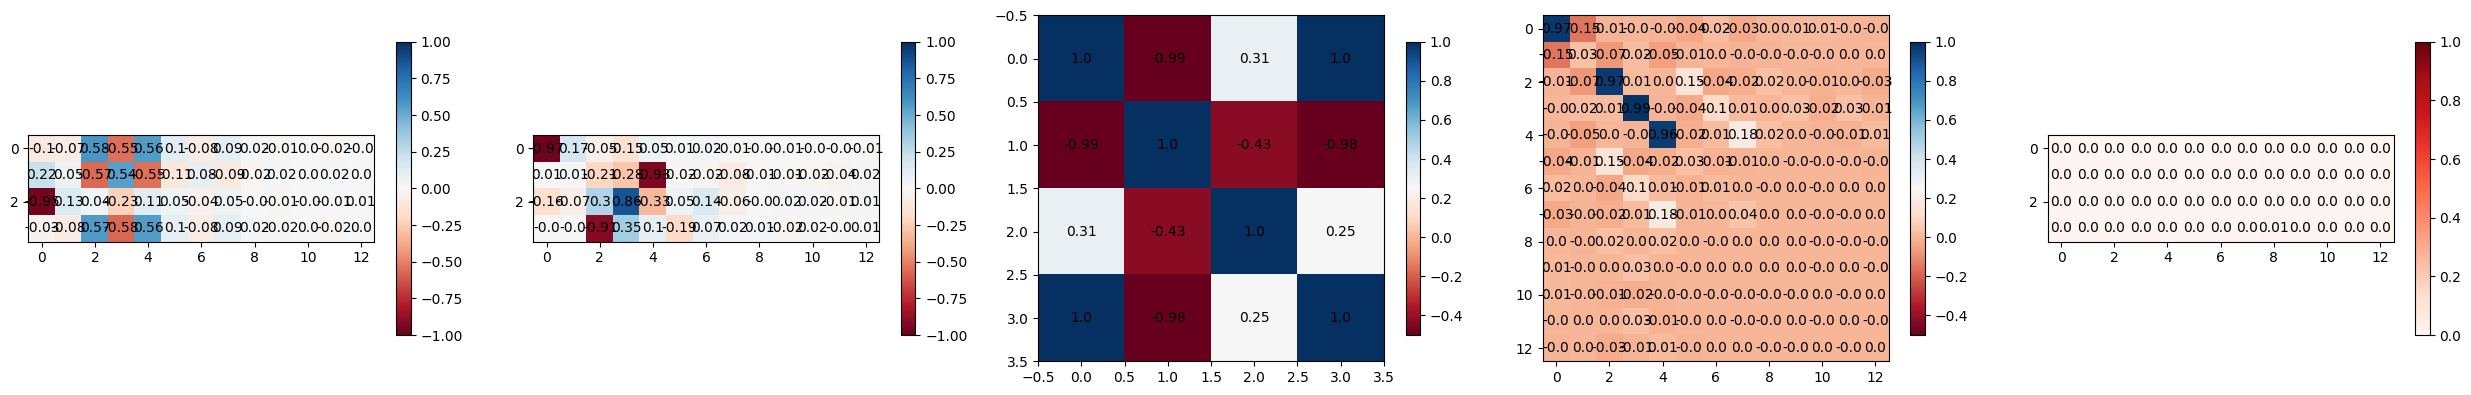

2H2O_rotations/phi_00/2H2O_pao44-1_0.pao: 4.046844e-02


In [614]:
batch_size = 1
path = Path("2H2O_rotations/phi_00/2H2O_pao44-1_0.pao")
test_pao_objects = generate_pao_object_from_file(path)
test_pao_objects_O = [pao_object for pao_object in test_pao_objects if pao_object.kind.atomic_number==8]
test_data_O = []
for pao_object in test_pao_objects_O:
    test_data_O += [
        Data(
            x=None, pos=pao_object.coords, y=pao_object.label, z=generate_f_in(pao_object)
        )
    ]
prim_basis_spec = prim_basis_specs["O"]
prim_basis_size = o3.Irreps(prim_basis_spec).dim

for idx, pao_object in enumerate(test_data_O):
    edge_vecs = x.pos
    atomkinds = x.z
    label = x.y
    pred = model_O(edge_vecs, atomkinds).squeeze()
    label_projector = label.T @ torch.inverse(label @ label.T) @ label
    pred_projector = pred.T @ torch.inverse(pred @ pred.T) @ pred
    print(label.pow(2).sum(dim=0))
    print(pred.squeeze().pow(2).sum(dim=0))
    fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(25.0, 4.0))
    ax0 = axs[0].imshow(pred.squeeze().detach(), cmap="RdBu",vmin=-1, vmax=1)
    ax1 = axs[1].imshow(test_pao_objects_O[idx].xblock, cmap="RdBu",vmin=-1, vmax=1)
    #ax2 = axs[2].imshow(pred_projector.detach(), cmap="RdBu",vmin=-0.5, vmax=1)
    ax2 = axs[2].imshow((pred@pred.T).detach(), cmap="RdBu",vmin=-0.5, vmax=1)
    ax3 = axs[3].imshow(label_projector.detach(), cmap="RdBu",vmin=-0.5, vmax=1)
    ax4 = axs[4].imshow((pred.T-label_projector@pred.T).T.abs().detach(), cmap="Reds",vmin=0, vmax=1)
    for (j,i),label in np.ndenumerate(pred.squeeze().detach()):
        axs[0].text(i,j,round(label,2),ha='center',va='center')
    for (j,i),label in np.ndenumerate(test_pao_objects_O[idx].xblock):
        axs[1].text(i,j,round(label,2),ha='center',va='center')
    for (j,i),label in np.ndenumerate((pred@pred.T).detach()):
        axs[2].text(i,j,round(label,2),ha='center',va='center')
    for (j,i),label in np.ndenumerate(label_projector.detach()):
        axs[3].text(i,j,round(label,2),ha='center',va='center')
    for (j,i),label in np.ndenumerate((pred.T-label_projector@pred.T).T.abs().detach()):
        axs[4].text(i,j,round(label,2),ha='center',va='center')

    fig.colorbar(ax0, ax=axs[0], shrink=0.8)
    fig.colorbar(ax1, ax=axs[1], shrink=0.8)
    fig.colorbar(ax2, ax=axs[2], shrink=0.8)
    fig.colorbar(ax3, ax=axs[3], shrink=0.8)
    fig.colorbar(ax4, ax=axs[4], shrink=0.8)
    plt.tight_layout()
    plt.show()
    test_mae = (pred.T-label_projector@pred.T).abs().sum()
    print(f"{path}: {test_mae:e}")

# Hydrogen

In [9]:
prim_basis_size = o3.Irreps(prim_basis_specs["H"]).dim
prim_basis_spec = prim_basis_specs["H"]
irreps_output = generate_irreps_output(pao_basis_size, "H")
D_H = irreps_output.D_from_matrix(change_of_coord)
#plt.imshow(D_H, cmap="RdBu", vmin=-1, vmax=1)
#plt.colorbar()

In [10]:
batch_size = 1
data_H = []
#dataset_H = PAO_dataset(pao_objects_H)
#training_loader_H = DataLoader(dataset_H, batch_size=batch_size, shuffle=True)

for pao_object in pao_objects_H[2:]:
    data_H += [
        Data(
            x=None, pos=pao_object.coords, y=pao_object.label, z=generate_f_in(pao_object)
        )
    ]
train_loader_H = DataLoader(
    data_H, batch_size=batch_size, shuffle=False
)

In [11]:
# Torch module for learnable rotation matrix
class RotationMatrix(torch.nn.Module):
    def __init__(self, dimension):
        super(RotationMatrix, self).__init__()
        self.dim = dimension
        self.angles = torch.nn.Parameter(torch.tensor(np.random.randn(int((dimension-1)*dimension/2)), dtype=torch.float32), requires_grad=True)

    def forward(self, x):
        rotation_matrix = torch.eye(self.dim)

        i = 0
        for idx in range(self.dim):
            for jdx in range(idx+1, self.dim):
                vec1 = torch.zeros(self.dim)
                vec1[idx] = 1
                vec2 = torch.zeros(self.dim)
                vec2[jdx] = 1
                V = torch.outer(vec1, vec1) + torch.outer(vec2, vec2)
                W = torch.outer(vec1, vec2) - torch.outer(vec2, vec1)
                temp_rotation_matrix = torch.eye(self.dim) + (torch.cos(self.angles[i])-1)*V + torch.sin(self.angles[i])*W
                rotation_matrix = temp_rotation_matrix*rotation_matrix
                i+=1
        
        y = torch.matmul(rotation_matrix, x)

        return y

In [78]:
def generate_rotation_matrix(dimension, angles):
    angles = t(angles, dtype=torch.float32)
    rotation_matrix = torch.eye(dimension)

    i = 0
    for idx in range(dimension):
        for jdx in range(idx+1, dimension):
            vec1 = torch.zeros(dimension)
            vec1[idx] = 1
            vec2 = torch.zeros(dimension)
            vec2[jdx] = 1
            V = torch.outer(vec1, vec1) + torch.outer(vec2, vec2)
            W = torch.outer(vec1, vec2) - torch.outer(vec2, vec1)
            temp_rotation_matrix = torch.eye(dimension) + (torch.cos(angles[i])-1)*V + torch.sin(angles[i])*W
            rotation_matrix = temp_rotation_matrix @ rotation_matrix
            i+=1
    return rotation_matrix

def rotation_cost(angles, dimension, pred, label):
    rotation_matrix = generate_rotation_matrix(dimension, angles)   
    rot_pred = torch.matmul(rotation_matrix, pred.T).T
    cost = (rot_pred - label).pow(2).sum()
    return cost

In [79]:
elem_basis = t(
    [[1.0, 0.0, 0.0, 0.0, 0.0],
     [0.0, 1.0, 0.0, 0.0, 0.0],
     [0.0, 0.0, 1.0, 0.0, 0.0],
     [0.0, 0.0, 0.0, 1.0, 0.0],
     [0.0, 0.0, 0.0, 0.0, 1.0]])
angles_1 = t([np.pi/3, np.pi/8, np.pi/7, np.pi/4, np.pi/8, np.pi/3, np.pi/9, np.pi/9, np.pi/17, np.pi/3])
angles_2 = torch.rand(10, dtype=torch.float32)
rot_mat_1 = generate_rotation_matrix(5, angles_1)
rot_mat_2 = generate_rotation_matrix(5, angles_2)
new_basis = torch.matmul(rot_mat_1, elem_basis.T).T
final = torch.matmul(rot_mat_2, new_basis.T).T

pred_angles = torch.rand(10, dtype=torch.float32)
opt_res = sp.optimize.minimize(rotation_cost, pred_angles, args=(5, new_basis, final), method="COBYLA", options={"maxiter": 1000})

/var/folders/fg/yx126zds0dj8sxfjmyj39t3c0000gn/T/ipykernel_53732/1486231158.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  angles = t(angles, dtype=torch.float32)


In [82]:
pred_rot_mat = generate_rotation_matrix(5, opt_res.x)
pred_final = torch.matmul(pred_rot_mat, new_basis.T).T
print((final - pred_final).abs().mean())
print((rot_mat_2 - pred_rot_mat).abs().mean())

tensor(6.8715e-05)
tensor(6.1152e-05)


In [13]:
# Torch Module for PAO learning
class PAO_model(torch.nn.Module):
    def __init__(self, max_radius, pao_basis_size, prim_basis_size, irreps_input, irreps_sh, irreps_output):
        super(PAO_model, self).__init__()
        change_of_coord = t([
            [0., 0., 1.],
            [1., 0., 0.],
            [0., 1., 0.]
        ]) 
        self.dim = prim_basis_size
        self.max_radius = max_radius
        self.num_distances = 10
        self.num_neighbours = 4
        self.pao_basis_size = pao_basis_size
        self.prim_basis_size = prim_basis_size
        self.irreps_sh = irreps_sh
        #self.rot = RotationMatrix(self.dim)
        self.tp =  o3.FullyConnectedTensorProduct(irreps_input, irreps_sh, irreps_output, shared_weights=False)

        num_layers = 32
        self.fc = FullyConnectedNet([self.num_distances, num_layers, self.tp.weight_numel], torch.relu)
        self.coord_change = irreps_output.D_from_matrix(change_of_coord)

    def forward(self, edge_vec, f_in):
        sh = o3.spherical_harmonics(self.irreps_sh, edge_vec, normalize=True, normalization='component')
        emb = soft_one_hot_linspace(edge_vec.norm(dim=1), 0.0, self.max_radius, self.num_distances,
                                    basis='smooth_finite', cutoff=True).mul(self.num_distances**0.5)
        flat_xyz = self.tp(f_in, sh, self.fc(emb)).sum(dim=0).div(self.num_neighbours**0.5)
        flat_yzx = torch.matmul(flat_xyz, self.coord_change).reshape(self.pao_basis_size, self.prim_basis_size)
        #rot_flat_yzx = self.rot(flat_yzx.T).T
        return flat_yzx

In [34]:
max_radius = 4.0
model_H = PAO_model(
    max_radius=max_radius,
    pao_basis_size=pao_basis_size,
    prim_basis_size=prim_basis_size, 
    irreps_input=irreps_input,
    irreps_sh=irreps_sh,
    irreps_output=irreps_output
)

/Users/Vincente/anaconda3/envs/e3nn/lib/python3.11/site-packages/torch/jit/_check.py:172: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn("The TorchScript type system doesn't support "


In [35]:
# Train the model.
#M_H = Network(generate_irreps_output(4, "H"))
optim = torch.optim.Adam(model_H.parameters(), lr=1e-3)
train_loss_H = []

for step in range(1001):
    temp_loss = 0
    i = 0
    for x in data_H:
        edge_vecs = x.pos
        atomkinds = x.z
        label = x.y
        pred = model_H(edge_vecs, atomkinds)
        pred_copy = pred.detach().clone()
        angles = torch.rand(int((prim_basis_size-1)*prim_basis_size/2), dtype=torch.float32)
        opt_res = sp.optimize.minimize(rotation_cost, angles, args=(prim_basis_size, pred_copy, label.detach().clone()), method="COBYLA", options={"maxiter": 1000})
        rotation_matrix = generate_rotation_matrix(prim_basis_size, opt_res.x)    
        #loss = loss_function_ortho_projector(pred, label)
        loss = (torch.matmul(rotation_matrix, pred.T).T - label).abs().sum()
        optim.zero_grad()
        loss.backward()
        optim.step()
        if step % 100 == 0:
            temp_loss += loss.detach()
            i+=1
    if step % 100 == 0:
        temp_loss /= i
        train_loss_H.append(temp_loss)
        print(f"training {step:5d} | loss {temp_loss:.8e}")

training     0 | loss 5.75121212e+00
training   100 | loss 1.50424814e+00
training   200 | loss 6.21999204e-01
training   300 | loss 3.82150054e-01
training   400 | loss 7.00203598e-01
training   500 | loss 8.16619918e-02
training   600 | loss 1.06824435e-01
training   700 | loss 7.06991553e-01
training   800 | loss 2.13107899e-01
training   900 | loss 5.04072964e-01
training  1000 | loss 3.54196012e-01


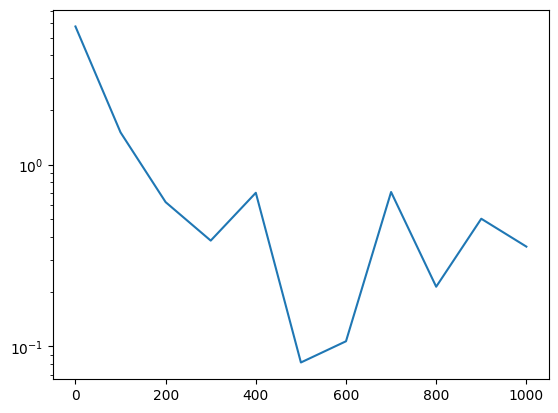

In [37]:
plt.plot(list(range(0, 1001,100)), train_loss_H)
plt.yscale("log")
plt.show()

tensor([1.0000, 1.0000, 1.0000, 1.0000])
tensor([0.5919, 2.0604, 1.1289, 1.2763], grad_fn=<SumBackward1>)


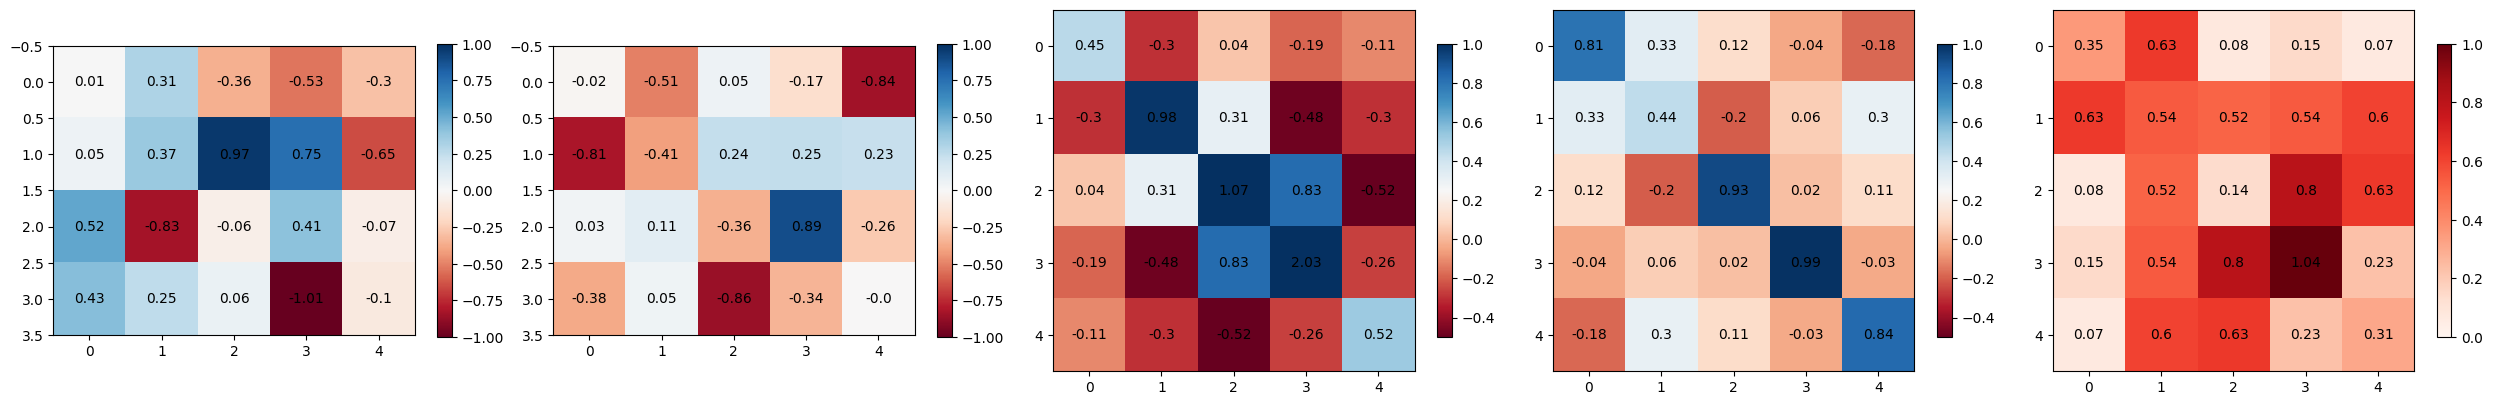

2H2O_rotations/rand_10/2H2O_pao44-1_0.pao: 1.088756e+01
tensor([1.0000, 1.0000, 1.0000, 1.0000])
tensor([0.5852, 2.0603, 1.1397, 1.2790], grad_fn=<SumBackward1>)


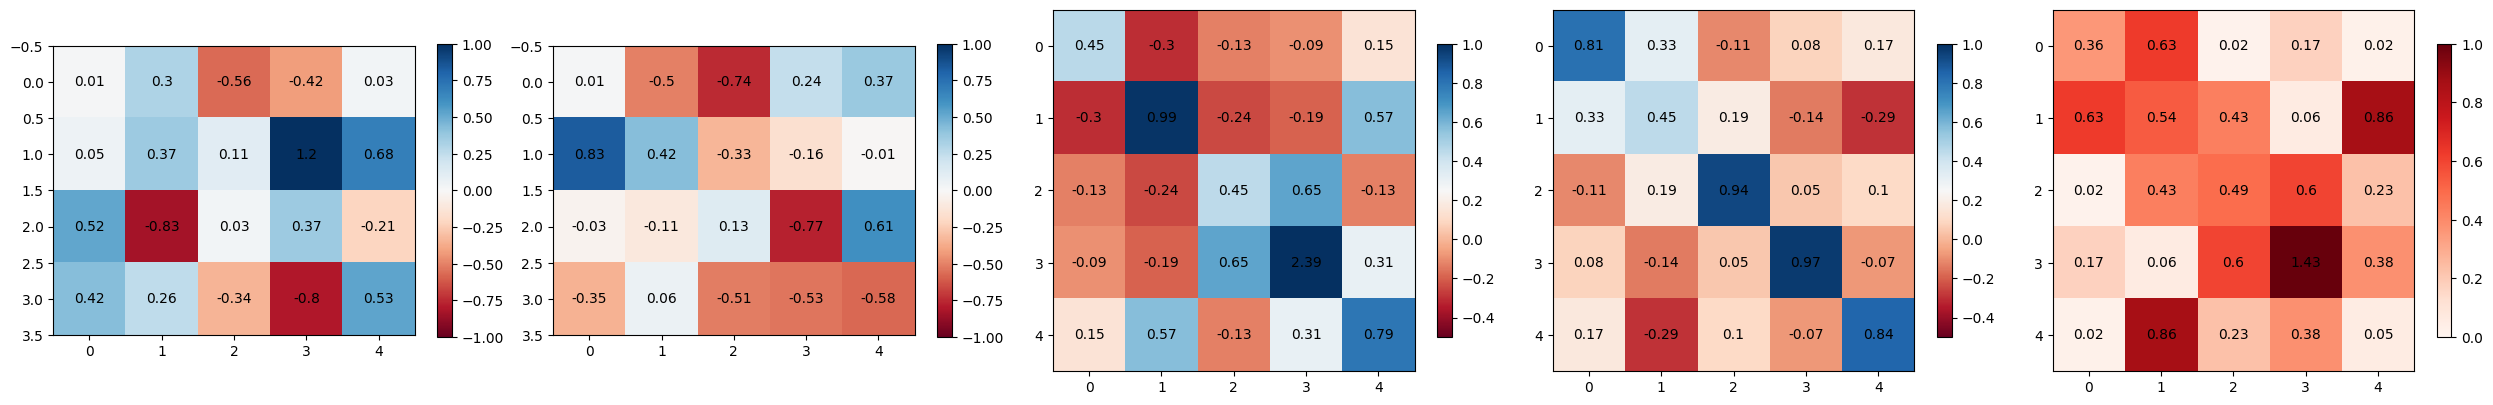

2H2O_rotations/rand_10/2H2O_pao44-1_0.pao: 9.675128e+00


In [40]:
batch_size = 1
path = Path("2H2O_rotations/rand_10/2H2O_pao44-1_0.pao")
test_pao_objects = generate_pao_object_from_file(path)
test_pao_objects_H = [pao_object for pao_object in test_pao_objects if pao_object.kind.atomic_number==1]
test_data_H = []
for pao_object in test_pao_objects_H:
    test_data_H += [
        Data(
            x=None, pos=pao_object.coords, y=pao_object.label, z=generate_f_in(pao_object)
        )
    ]
prim_basis_spec = prim_basis_specs["H"]
prim_basis_size = o3.Irreps(prim_basis_spec).dim

for idx, x in enumerate(test_data_H[:2]):
    edge_vecs = x.pos
    atomkinds = x.z
    label = x.y
    pred = model_H(edge_vecs, atomkinds).squeeze()
    #angles = torch.rand(int((prim_basis_size-1)*prim_basis_size/2), dtype=torch.float32)
    #opt_res = sp.optimize.minimize(rotation_cost, angles, args=(prim_basis_size, pred_copy, label.detach().clone()), method="COBYLA", options={"maxiter": 1000})
    #print(opt_res)
    #rotation_matrix = generate_rotation_matrix(prim_basis_size, opt_res.x)
    #pred = torch.matmul(rotation_matrix, pred.T).T    
        
    #label_projector = label.T @ torch.inverse(label @ label.T) @ label
    label_projector = label.T @ label
    #label_project = label
    #pred_projector = pred.T @ torch.inverse(pred @ pred.T) @ pred
    pred_projector = pred.T @ pred
    #print(torch.round(label @ label.T, decimals=2))
    #print(torch.round((pred.squeeze() @ pred.squeeze().T), decimals=2))
    print(label.pow(2).sum(dim=1))
    print(pred.squeeze().pow(2).sum(dim=1))
    fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(25.0, 4.0))
    ax0 = axs[0].imshow(pred.squeeze().detach(), cmap="RdBu",vmin=-1, vmax=1)
    ax1 = axs[1].imshow(x.y, cmap="RdBu",vmin=-1, vmax=1)
    ax2 = axs[2].imshow(pred_projector.detach(), cmap="RdBu",vmin=-0.5, vmax=1)
    ax3 = axs[3].imshow(label_projector.detach(), cmap="RdBu",vmin=-0.5, vmax=1)
    #ax4 = axs[4].imshow((pred.T-label_projector@pred.T).T.abs().detach(), cmap="Reds",vmin=0, vmax=1)
    ax4 = axs[4].imshow((pred_projector-label_projector).abs().detach(), cmap="Reds",vmin=0, vmax=1)
    for (j,i),label in np.ndenumerate(pred.squeeze().detach()):
        axs[0].text(i,j,round(label,2),ha='center',va='center')
    for (j,i),label in np.ndenumerate(x.y):
        axs[1].text(i,j,round(label,2),ha='center',va='center')
    for (j,i),label in np.ndenumerate(pred_projector.detach()):
        axs[2].text(i,j,round(label,2),ha='center',va='center')
    for (j,i),label in np.ndenumerate(label_projector.detach()):
        axs[3].text(i,j,round(label,2),ha='center',va='center')
    #for (j,i),label in np.ndenumerate((pred.T-label_projector@pred.T).T.abs().detach()):
    #    axs[4].text(i,j,round(label,2),ha='center',va='center')
    for (j,i),label in np.ndenumerate((pred_projector-label_projector).abs().detach()):
        axs[4].text(i,j,round(label,2),ha='center',va='center')
    #axs[0].imshow(pred.squeeze().detach(), cmap="RdBu", vmin=-1, vmax=1)
    #axs[1].imshow(test_pao_objects_H[idx].xblock.detach(), cmap="RdBu", vmin=-1, vmax=1)
    fig.colorbar(ax0, ax=axs[0], shrink=0.8)
    fig.colorbar(ax1, ax=axs[1], shrink=0.8)
    fig.colorbar(ax2, ax=axs[2], shrink=0.8)
    fig.colorbar(ax3, ax=axs[3], shrink=0.8)
    fig.colorbar(ax4, ax=axs[4], shrink=0.8)
    plt.tight_layout()
    plt.show()
    test_mae = (pred_projector-label_projector).abs().sum()
    print(f"{path}: {test_mae:e}")

In [ ]:
batch_size=1
for path in sorted(Path().glob("2H2O_rotations/rand_*/2H2O_pao44-1_0.pao")):
    pao_objects = generate_pao_object_from_file(path)
    pao_objects_O = [pao_object for pao_object in pao_objects if pao_object.kind.atomic_number==8]
    pao_objects_H = [pao_object for pao_object in pao_objects if pao_object.kind.atomic_number==1]
    kinds, atom2kind, sample_coords, sample_xblocks = parse_pao_file_torch(path)
    pred_xblocks = sample_xblocks.copy()
    
    prim_basis_size = o3.Irreps(prim_basis_specs["O"]).dim    
    pred_xblocks[0] = model_O(pao_objects_O[0].coords.unsqueeze(dim=0), generate_f_in(pao_objects_O[0]).unsqueeze(dim=0)).squeeze()
    pred_xblocks[3] = model_O(pao_objects_O[1].coords.unsqueeze(dim=0), generate_f_in(pao_objects_O[1]).unsqueeze(dim=0)).squeeze()
    
    prim_basis_size = o3.Irreps(prim_basis_specs["H"]).dim
    pred_xblocks[1] = model_H(pao_objects_H[0].coords.unsqueeze(dim=0), generate_f_in(pao_objects_H[0]).unsqueeze(dim=0)).squeeze()
    pred_xblocks[2] = model_H(pao_objects_H[1].coords.unsqueeze(dim=0), generate_f_in(pao_objects_H[1]).unsqueeze(dim=0)).squeeze()
    pred_xblocks[4] = model_H(pao_objects_H[2].coords.unsqueeze(dim=0), generate_f_in(pao_objects_H[2]).unsqueeze(dim=0)).squeeze()
    pred_xblocks[5] = model_H(pao_objects_H[3].coords.unsqueeze(dim=0), generate_f_in(pao_objects_H[3]).unsqueeze(dim=0)).squeeze()
    
    write_pao_file(path.parent / "2H2O_pao44_eval.pao", kinds, atom2kind, sample_coords, pred_xblocks)
    ! cd {path.parent}; OMP_NUM_THREADS=8 /data/vdella/software/cp2k/exe/local/cp2k.sdbg 2H2O_pao44_eval.inp > 2H2O_pao44_eval.out
    test_energy = read_cp2k_energy(path.parent / "2H2O_pao44_eval.out")
    ref_energy = read_cp2k_energy(path.parent / "2H2O_pao44.out")
    rel_diff_energy = (test_energy - ref_energy) / ref_energy
    print(f"{path}: Relative Energy Diff: {rel_diff_energy:e}")
    ! grep "SCF run converged in" {path.parent}/2H2O_pao44_eval.out

In [ ]:
class Convolution(torch.nn.Module):
    r"""equivariant convolution

    Parameters
    ----------
    irreps_in : `e3nn.o3.Irreps`
        representation of the input node features

    irreps_node_attr : `e3nn.o3.Irreps`
        representation of the node attributes

    irreps_edge_attr : `e3nn.o3.Irreps`
        representation of the edge attributes

    irreps_out : `e3nn.o3.Irreps` or None
        representation of the output node features

    number_of_basis : int
        number of basis on which the edge length are projected

    radial_layers : int
        number of hidden layers in the radial fully connected network

    radial_neurons : int
        number of neurons in the hidden layers of the radial fully connected network

    num_neighbors : float
        typical number of nodes convolved over
    """
    def __init__(
        self,
        irreps_in,
        irreps_node_attr,
        irreps_edge_attr,
        irreps_out,
        number_of_basis,
        radial_layers,
        radial_neurons,
        num_neighbors
    ) -> None:
        super().__init__()
        self.irreps_in = o3.Irreps(irreps_in)
        self.irreps_node_attr = o3.Irreps(irreps_node_attr)
        self.irreps_edge_attr = o3.Irreps(irreps_edge_attr)
        self.irreps_out = o3.Irreps(irreps_out)
        self.num_neighbors = num_neighbors

        self.sc = FullyConnectedTensorProduct(self.irreps_in, self.irreps_node_attr, self.irreps_out)

        self.lin1 = FullyConnectedTensorProduct(self.irreps_in, self.irreps_node_attr, self.irreps_in)

        irreps_mid = []
        instructions = []
        for i, (mul, ir_in) in enumerate(self.irreps_in):
            for j, (_, ir_edge) in enumerate(self.irreps_edge_attr):
                for ir_out in ir_in * ir_edge:
                    if ir_out in self.irreps_out:
                        k = len(irreps_mid)
                        irreps_mid.append((mul, ir_out))
                        instructions.append((i, j, k, 'uvu', True))
        irreps_mid = o3.Irreps(irreps_mid)
        irreps_mid, p, _ = irreps_mid.sort()

        instructions = [
            (i_1, i_2, p[i_out], mode, train)
            for i_1, i_2, i_out, mode, train in instructions
        ]

        tp = TensorProduct(
            self.irreps_in,
            self.irreps_edge_attr,
            irreps_mid,
            instructions,
            internal_weights=False,
            shared_weights=False,
        )
        self.fc = FullyConnectedNet([number_of_basis] + radial_layers * [radial_neurons] + [tp.weight_numel], torch.nn.functional.silu)
        self.tp = tp

        self.lin2 = FullyConnectedTensorProduct(irreps_mid, self.irreps_node_attr, self.irreps_out)

    def forward(self, node_input, node_attr, edge_src, edge_dst, edge_attr, edge_length_embedded) -> torch.Tensor:
        weight = self.fc(edge_length_embedded)

        x = node_input

        s = self.sc(x, node_attr)
        x = self.lin1(x, node_attr)

        edge_features = self.tp(x[edge_src], edge_attr, weight)
        x = scatter(edge_features, edge_dst, dim=0, dim_size=x.shape[0]).div(self.num_neighbors**0.5)

        x = self.lin2(x, node_attr)

        c_s, c_x = math.sin(math.pi / 8), math.cos(math.pi / 8)
        m = self.sc.output_mask
        c_x = (1 - m) + c_x * m
        return c_s * s + c_x * x